In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from  traces_visualization import prepare_denoise_data
import numpy as np
import os
#running python script properly
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Define the custom dataset class
class NoisyDataset(Dataset):
    """A dataset that adds noise to the original data based on SNR."""
    
    def __init__(self, original_dataset, snr_value):
        self.original_dataset = original_dataset
        self.snr_value = abs(snr_value)  # Ensure the SNR value is positive
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        pure_data = self.original_dataset[idx]
        if not isinstance(pure_data, torch.Tensor):
            pure_data = torch.tensor(pure_data, dtype=torch.float32)
        
        signal_abs = torch.abs(pure_data)
        S = torch.max(signal_abs)
        
        # Ensure N is never negative
        N = S / self.snr_value  # Prevent division by zero or negative values
        
        noise = torch.normal(0, N.item(), pure_data.size())
        noisy_data = pure_data + noise
        # noisy_data = torch.clamp(noisy_data, -1., 1.)
        
        return pure_data, noisy_data, self.snr_value

# Define the Autoencoder model class
class Autoencoder(nn.Module):
    """A simple Autoencoder model."""
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(32, 1, 4, stride=2, padding=1),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

def initialize_model(learning_rate=0.001):
    """Initialize the model and optimizer."""
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer


# Preparation for training
train_loader, valid_loader, test_loader = prepare_denoise_data(ndat_train=1, ndat_valid=1, ndat_test=1, batch_size=1)
pure_train_loader = DataLoader(train_loader.dataset, batch_size=1, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device set to: {device}')

model, optimizer = initialize_model()
criterion = nn.MSELoss()
num_epochs = 1000
train_losses = []
test_losses = [[] for _ in range(num_epochs)]  # Initialize a list of lists for test losses


# Training Phase
# Train on the pure single 'pure signal' sample
pure_train_loader = DataLoader(NoisyDataset(train_loader.dataset, snr_value=float('inf')), batch_size=16, shuffle=True)


snr_values = [0.5, 0.8, 1, 2, 3]  # SNR values
train_datasets = {snr: NoisyDataset(original_dataset, snr) for snr in snr_values}
train_loaders = {snr: DataLoader(dataset, batch_size=16, shuffle=True) for snr, dataset in train_datasets.items()}
average_test_loss_per_epoch = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for pure_data, noisy_data, _ in pure_train_loader:
        pure_data, noisy_data = pure_data.to(device), noisy_data.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_data)
        loss = criterion(outputs, pure_data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(pure_train_loader))

    # Evaluation Phase
    # Evaluate the model on the noisy test data
    snr_range = [5,30,5]
    model.eval()
    epoch_test_losses = []
    for snr_value in snr_range:
        noisy_test_loader = DataLoader(NoisyDataset(test_loader.dataset, snr_value=snr_value), batch_size=16, shuffle=True)
        test_loss = 0.0
        with torch.no_grad():
            for pure_data, noisy_data, _ in noisy_test_loader:
                pure_data, noisy_data = pure_data.to(device), noisy_data.to(device)
                outputs = model(noisy_data)
                loss = criterion(outputs, pure_data)
                test_loss += loss.item()
        test_loss /= len(noisy_test_loader)
        epoch_test_losses.append(test_loss)  # Collect test loss for the current epoch and SNR
    test_losses[epoch] = np.mean(epoch_test_losses)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[epoch]:.4f}')


# Training data 
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss',color='blue')
plt.plot(test_losses, label='Test Loss',  color='red')  # Now plotting a list of average test losses
plt.xlabel(xlabel = 'Epoch', fontsize=16)
plt.ylabel(ylabel ='Loss', fontsize=16)
plt.title(label = 'Training and Test Loss over Epochs', fontsize = 20)
plt.legend()
plt.show()
snr_values = [float('inf'), 20,10,5,1,0.1,0.01,0]  # Example SNR values 
model.eval()
with torch.no_grad():
    for snr_value in snr_values:
        noisy_train_loader = DataLoader(NoisyDataset(train_loader.dataset, snr_value=snr_value), batch_size=1, shuffle=False)
        for pure_data, noisy_data, _ in noisy_train_loader:
            pure_data, noisy_data = pure_data.to(device), noisy_data.to(device)
            denoised_output = model(noisy_data)

            plt.figure(figsize=(18, 6))
            
            # Subplot for Pure and Denoised data
            plt.subplot(2, 1, 1)
            plt.plot(pure_data.cpu().squeeze(), label='Pure', color='blue')
            plt.plot(denoised_output.cpu().squeeze(), label=f'Denoised SNR = {snr_value}', linestyle='--', color='orange')
            plt.title(f'Comparison of Pure and Denoised Data at SNR = {snr_value}', )
            plt.legend(fontsize = 16)
            
            # Subplot for Noisy data
            plt.subplot(2, 1, 2)
            plt.plot(noisy_data.cpu().squeeze(), label=f'Noisy SNR = {snr_value}', color='red')
            plt.title(f'Noisy Data at SNR = {snr_value}')
            plt.legend(fontsize = 16)
            
            # plt.tight_layout()
            plt.show()

print('Evaluation of Train dataset is complete')

# Test data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss',color='blue')
plt.plot(test_losses, label='Test Loss',  color='red')  # Now plotting a list of average test losses
plt.xlabel(xlabel = 'Epoch', fontsize=16)
plt.ylabel(ylabel ='Loss', fontsize=16)
plt.title(label = 'Training and Test Loss over Epochs', fontsize = 20)
plt.legend()
plt.show()
snr_values = [float('inf'), 20,10,5,1,0.1,0.0001,0]  # Example SNR values 
model.eval()
with torch.no_grad():
    for snr_value in snr_values:
        noisy_train_loader = DataLoader(NoisyDataset(test_loader.dataset, snr_value=snr_value), batch_size=1, shuffle=False)
        for pure_data, noisy_data, _ in noisy_train_loader:
            pure_data, noisy_data = pure_data.to(device), noisy_data.to(device)
            denoised_output = model(noisy_data)

            plt.figure(figsize=(18, 6))
            
            # Subplot for Pure and Denoised data
            plt.subplot(2, 1, 1)
            plt.plot(pure_data.cpu().squeeze(), label='Pure', color='blue')
            plt.plot(denoised_output.cpu().squeeze(), label=f'Denoised SNR = {snr_value}', linestyle='--', color='orange')
            plt.title(f'Comparison of Pure and Denoised Data at SNR = {snr_value}', )
            plt.legend(fontsize = 16)
            
            # Subplot for Noisy data
            plt.subplot(2, 1, 2)
            plt.plot(noisy_data.cpu().squeeze(), label=f'Noisy SNR = {snr_value}', color='red')
            plt.title(f'Noisy Data at SNR = {snr_value}')
            plt.legend(fontsize = 16)
            
            # plt.tight_layout()
            plt.show()

print('Evaluation of Test dataset is complete')

Device set to: cuda:0


NameError: name 'original_dataset' is not defined

Device set to: cuda:0
Epoch 1/100, Training Loss: 0.0093, Test Loss: 0.1882
Epoch 2/100, Training Loss: 0.0114, Test Loss: 0.1851
Epoch 3/100, Training Loss: 0.0122, Test Loss: 0.2366
Epoch 4/100, Training Loss: 0.0127, Test Loss: 0.2429
Epoch 5/100, Training Loss: 0.0130, Test Loss: 0.2639
Epoch 6/100, Training Loss: 0.0152, Test Loss: 0.1050
Epoch 7/100, Training Loss: 0.0123, Test Loss: 0.2217
Epoch 8/100, Training Loss: 0.0137, Test Loss: 0.1543
Epoch 9/100, Training Loss: 0.0163, Test Loss: 0.0131
Epoch 10/100, Training Loss: 0.0132, Test Loss: 0.0131
Epoch 11/100, Training Loss: 0.0132, Test Loss: 0.0131
Epoch 12/100, Training Loss: 0.0122, Test Loss: 0.0989
Epoch 13/100, Training Loss: 0.0144, Test Loss: 0.0131
Epoch 14/100, Training Loss: 0.0109, Test Loss: 0.1207
Epoch 15/100, Training Loss: 0.0145, Test Loss: 0.0259
Epoch 16/100, Training Loss: 0.0106, Test Loss: 0.0986
Epoch 17/100, Training Loss: 0.0125, Test Loss: 0.0789
Epoch 18/100, Training Loss: 0.0125, Test Loss: 0.13

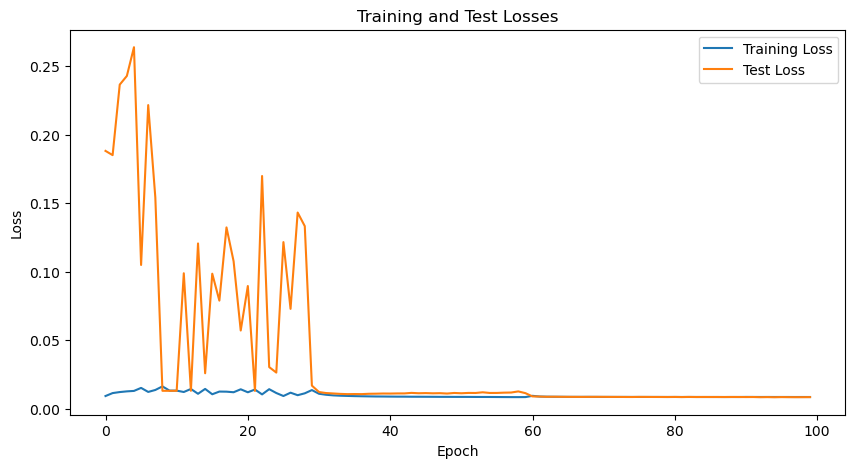

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class Autoencoder(nn.Module):
    """An Autoencoder model with batch normalization."""
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(32, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device set to: {device}')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Learning rate scheduler


num_epochs = 100
train_losses = []
test_losses = []
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    num_train_batches = 0

    # Training phase
    for snr, train_loader in train_loaders.items():
        for data in train_loader:
            # Adjusted to match the NoisyDataset output
            pure_data, noisy_data = data[1].to(device), data[0].to(device)
            optimizer.zero_grad()
            outputs = model(noisy_data)
            loss = criterion(outputs, pure_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1

    avg_train_loss = train_loss / num_train_batches
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    test_loss = 0.0
    num_test_batches = 0

    with torch.no_grad():
        for snr, test_loader in test_loaders.items():
            for data in test_loader:
                # Adjusted to match the NoisyDataset output
                pure_data, noisy_data = data[1].to(device), data[0].to(device)
                outputs = model(noisy_data)
                loss = criterion(outputs, pure_data)
                test_loss += loss.item()
                num_test_batches += 1

    avg_test_loss = test_loss / num_test_batches
    test_losses.append(avg_test_loss)

    # Save model checkpoint if test loss improved
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), 'autoencoder_best.pth')

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    scheduler.step()  # Update learning rate

    # Early stopping logic can be added here based on your criteria

# Plot training and test losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')  # Uncomment this line
plt.title('Training and Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

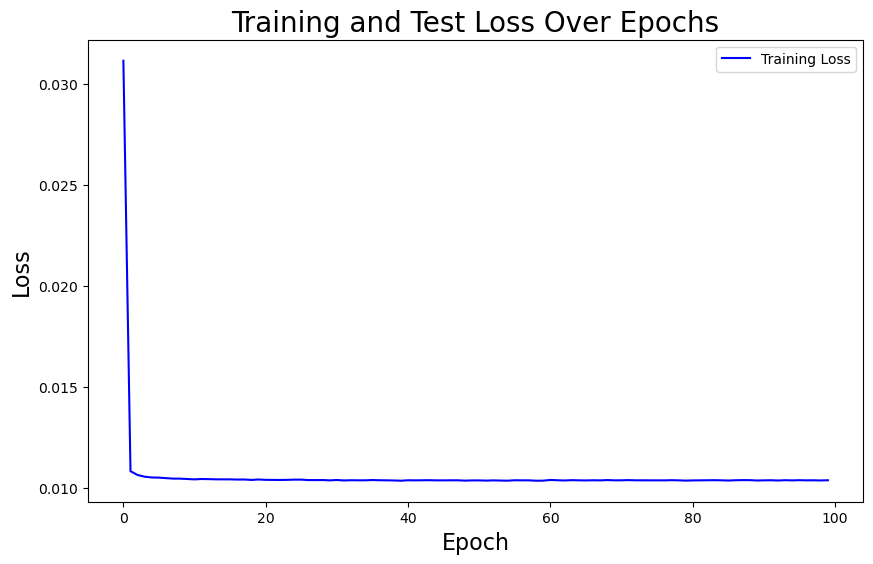

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Test Loss Over Epochs', fontsize=20)
plt.legend()
plt.show()

In [13]:
model.eval()  # Set the model to evaluation mode
snr_values = [10, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 3, 5, 7]
max_plots_per_snr = 2  # Set this to the desired number of plots per SNR

with torch.no_grad():
    for snr_value in snr_values:
        # Ensure that SNR value exists in the test_loaders dictionary
        if snr_value in test_loaders:
            test_loader = test_loaders[snr_value]
            plot_counter = 0  # Initialize plot counter for each SNR

            for data in test_loader:
                # Adjusted to match the NoisyDataset output
                noisy_data, pure_data = data
                # Ensure data is on the CPU and has the right shape: (batch_size, channels, sequence_length)
                pure_data = pure_data.to(device).view(-1, 1, pure_data.size(-1))
                noisy_data = noisy_data.to(device).view(-1, 1, noisy_data.size(-1))

                # Get model output
                denoised_output = model(noisy_data).detach().cpu().view(-1)

                if plot_counter >= max_plots_per_snr:
                    break  # Stop plotting if max plots per SNR are reached

                # Create a new figure for each sample to avoid overlap
                plt.figure(figsize=(12, 6))

                # Subplot for Pure and Denoised data
                plt.subplot(2, 1, 1)
                plt.plot(pure_data.view(-1).cpu(), label='Pure', color='blue')
                plt.plot(denoised_output, label=f'Denoised SNR = {snr_value}', linestyle='--', color='orange')
                plt.title(f'Comparison of Pure and Denoised Data at SNR = {snr_value}')
                plt.legend()

                # Subplot for Noisy data
                plt.subplot(2, 1, 2)
                plt.plot(noisy_data.view(-1).cpu(), label=f'Noisy SNR = {snr_value}', color='red')
                plt.title(f'Noisy Data at SNR = {snr_value}')
                plt.legend()

                plt.tight_layout()
                plt.show()

                plot_counter += 1  # Increment plot counter
        else:
            print(f'No data available for SNR value: {snr_value}')

print('Evaluation of Test dataset is complete')

KeyError: 10

In [37]:
#Training model 
# Define the Autoencoder model class
#AANother Batch model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    """An Autoencoder model with batch normalization."""
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.ConvTranspose1d(32, 1, 4, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device set to: {device}')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loaders = {snr: DataLoader(dataset, batch_size=16, shuffle=True) 
                 for snr, dataset in noisy_train_datasets.items()}

test_loaders = {snr: DataLoader(dataset, batch_size=16, shuffle=False) 
                for snr, dataset in noisy_test_datasets.items()}

num_epochs = 100  # Number of epochs
train_losses = []  # To store average loss per epoch
test_losses = []   # To store average test loss per epoch
for epoch in range(num_epochs):
    model.train()  # Training mode
    train_loss = 0.0
    num_train_batches = 0

    # Training phase
    for snr, train_loader in train_loaders.items():
        for pure_data, noisy_data, _ in train_loader:
            pure_data, noisy_data = pure_data.to(device), noisy_data.to(device)
            optimizer.zero_grad()
            outputs = model(noisy_data)
            loss = criterion(outputs, pure_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
    avg_train_loss = train_loss / num_train_batches
    train_losses.append(avg_train_loss)

    # Switch to evaluation mode
    model.eval()
    test_loss = 0.0
    num_test_batches = 0

    # Evaluation phase
    with torch.no_grad():
        for snr, test_loader in test_loaders.items():
            for pure_data, noisy_data, _ in test_loader:
                pure_data, noisy_data = pure_data.to(device), noisy_data.to(device)
                outputs = model(noisy_data)
                loss = criterion(outputs, pure_data)
                test_loss += loss.item()
                num_test_batches += 1
    avg_test_loss = test_loss / num_test_batches
    test_losses.append(avg_test_loss)

    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Device set to: cuda:0
Epoch 1/100, Training Loss: 0.0168, Test Loss: 21.0250
Epoch 2/100, Training Loss: 0.0116, Test Loss: 8.7855
Epoch 3/100, Training Loss: 0.0115, Test Loss: 0.8930
Epoch 4/100, Training Loss: 0.0115, Test Loss: 6.6262
Epoch 5/100, Training Loss: 0.0115, Test Loss: 0.3389
Epoch 6/100, Training Loss: 0.0114, Test Loss: 0.2144
Epoch 7/100, Training Loss: 0.0114, Test Loss: 0.0497
Epoch 8/100, Training Loss: 0.0114, Test Loss: 0.0392
Epoch 9/100, Training Loss: 0.0114, Test Loss: 0.1757


KeyboardInterrupt: 

Epoch 1/100, Training Loss: 0.0139, Test Loss: 0.1898
Epoch 2/100, Training Loss: 0.0121, Test Loss: 0.1853
Epoch 3/100, Training Loss: 0.0123, Test Loss: 0.1174
Epoch 4/100, Training Loss: 0.0122, Test Loss: 0.1689
Epoch 5/100, Training Loss: 0.0130, Test Loss: 0.0719
Epoch 6/100, Training Loss: 0.0114, Test Loss: 0.0639
Epoch 7/100, Training Loss: 0.0111, Test Loss: 0.0760
Epoch 8/100, Training Loss: 0.0105, Test Loss: 0.1885
Epoch 9/100, Training Loss: 0.0111, Test Loss: 0.2734
Epoch 10/100, Training Loss: 0.0151, Test Loss: 0.1108
Epoch 11/100, Training Loss: 0.0126, Test Loss: 0.1474
Epoch 12/100, Training Loss: 0.0148, Test Loss: 0.0130
Epoch 13/100, Training Loss: 0.0119, Test Loss: 0.0301
Epoch 14/100, Training Loss: 0.0117, Test Loss: 0.0517
Epoch 15/100, Training Loss: 0.0124, Test Loss: 0.0319
Epoch 16/100, Training Loss: 0.0110, Test Loss: 0.0537
Epoch 17/100, Training Loss: 0.0119, Test Loss: 0.0328
Epoch 18/100, Training Loss: 0.0120, Test Loss: 0.0273
Epoch 19/100, Train

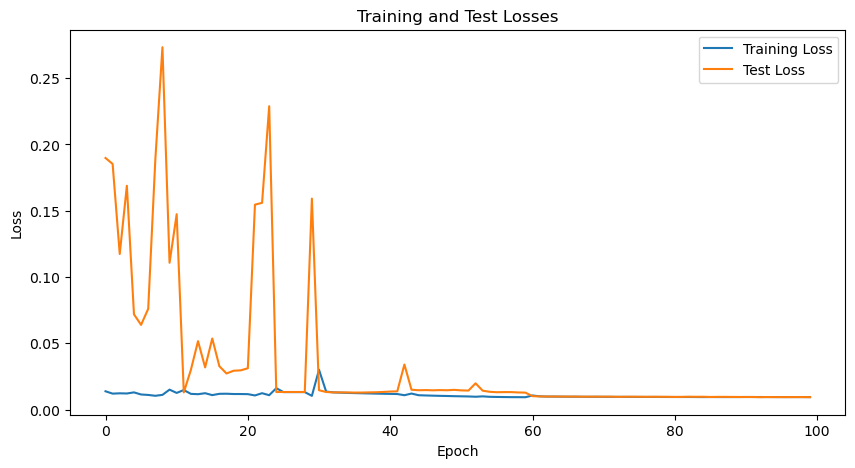

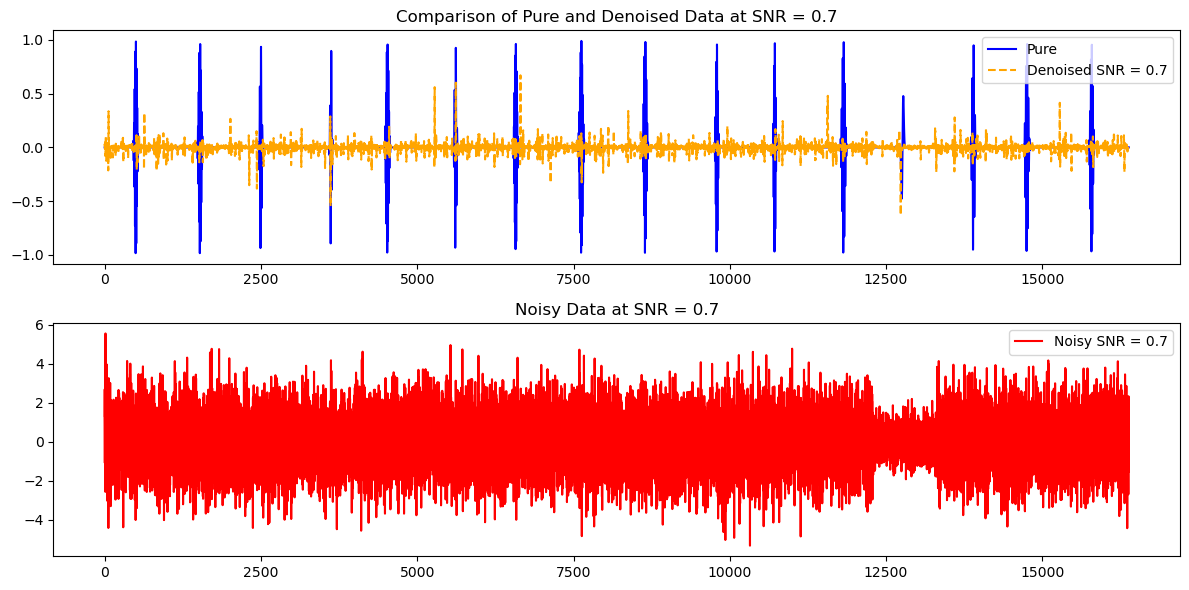

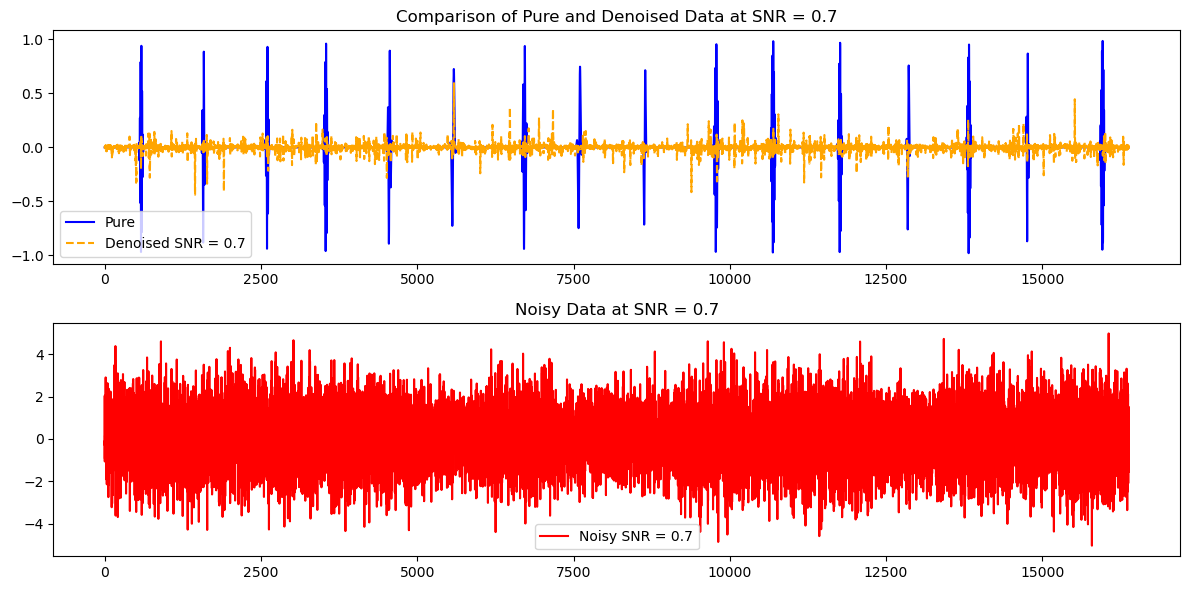

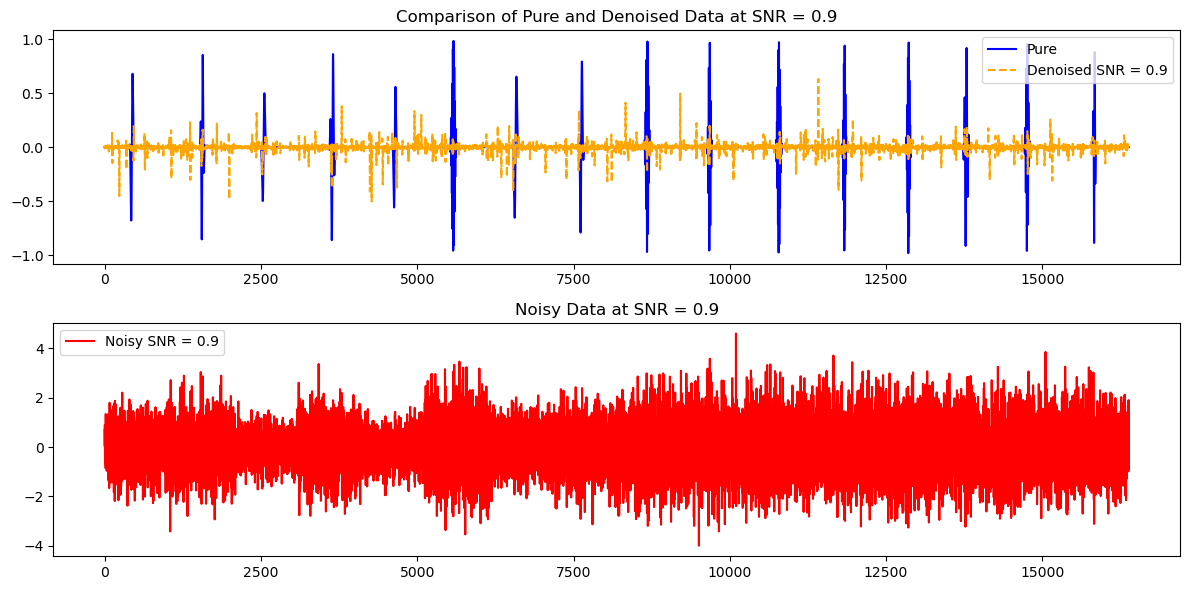

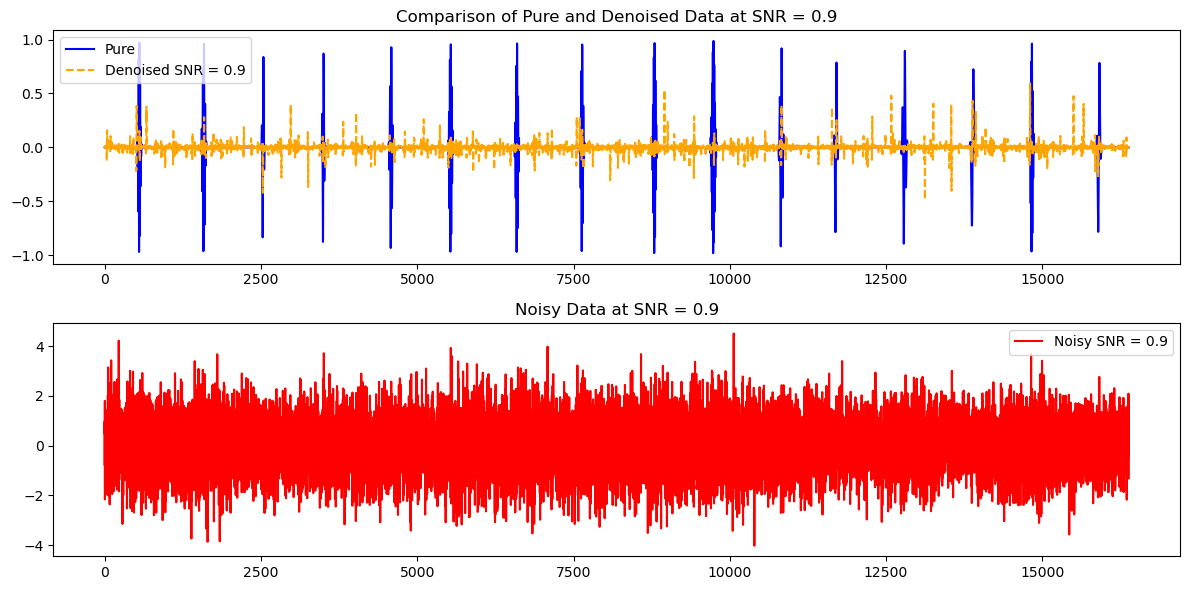

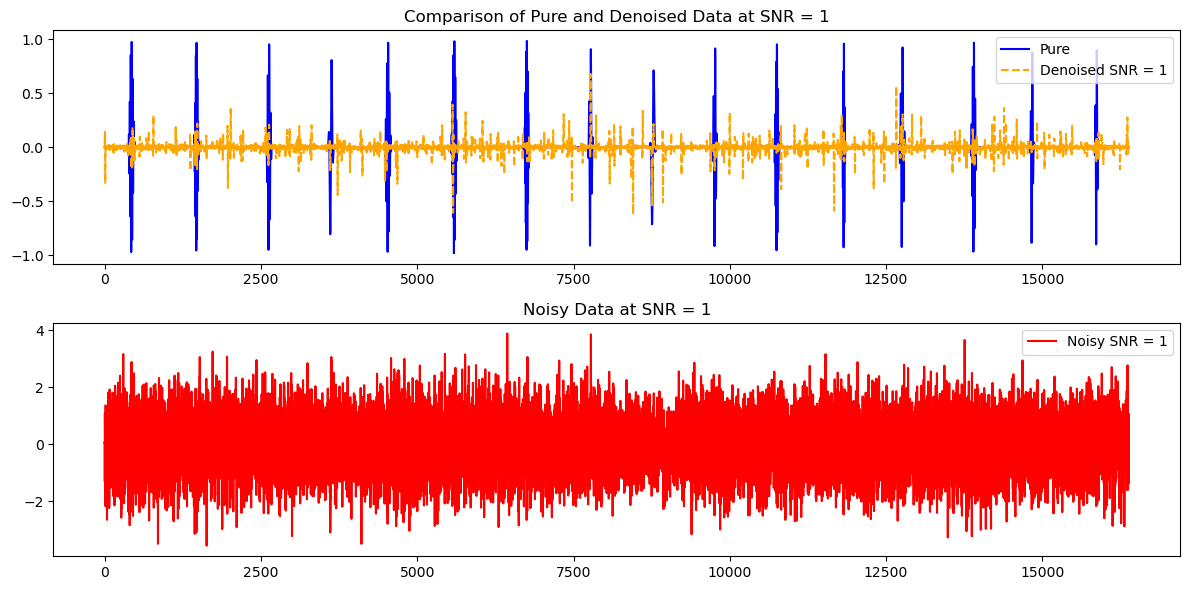

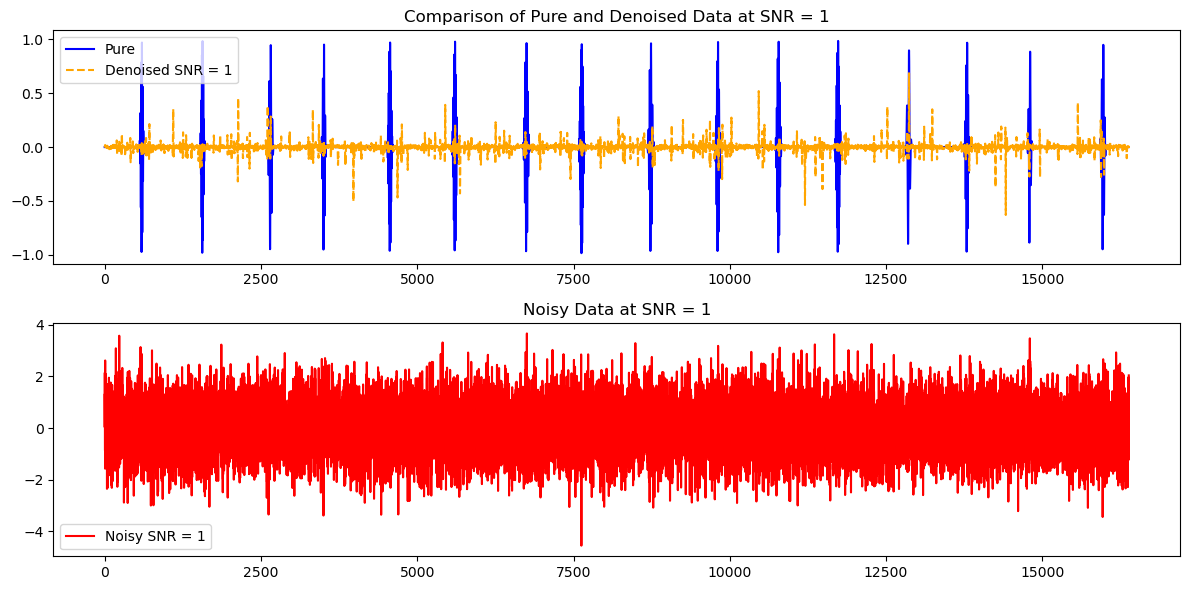

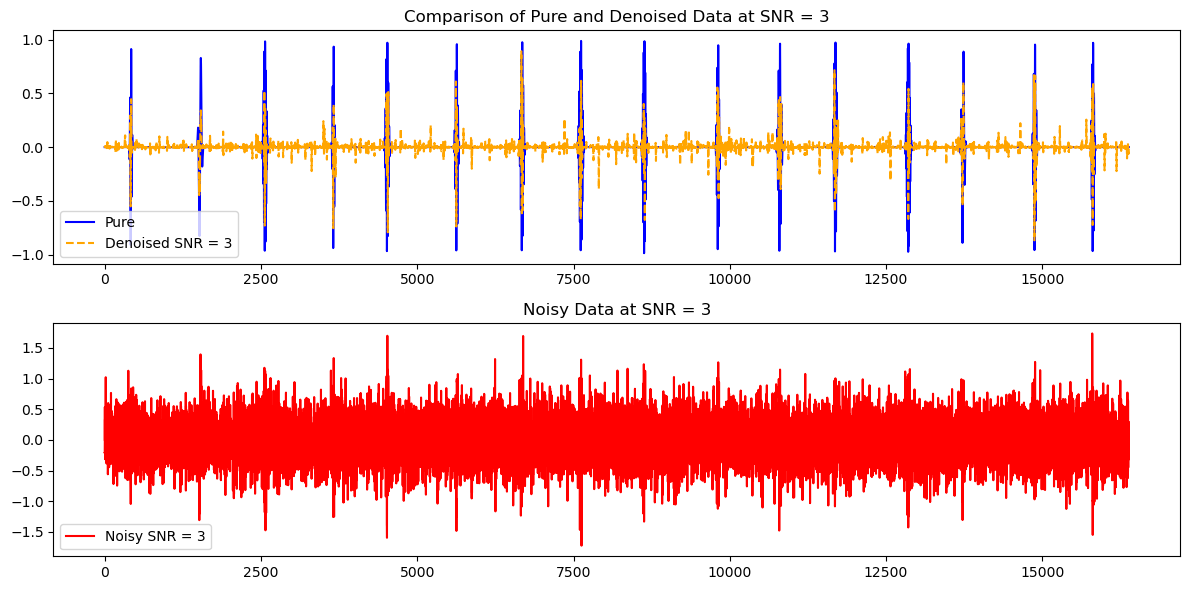

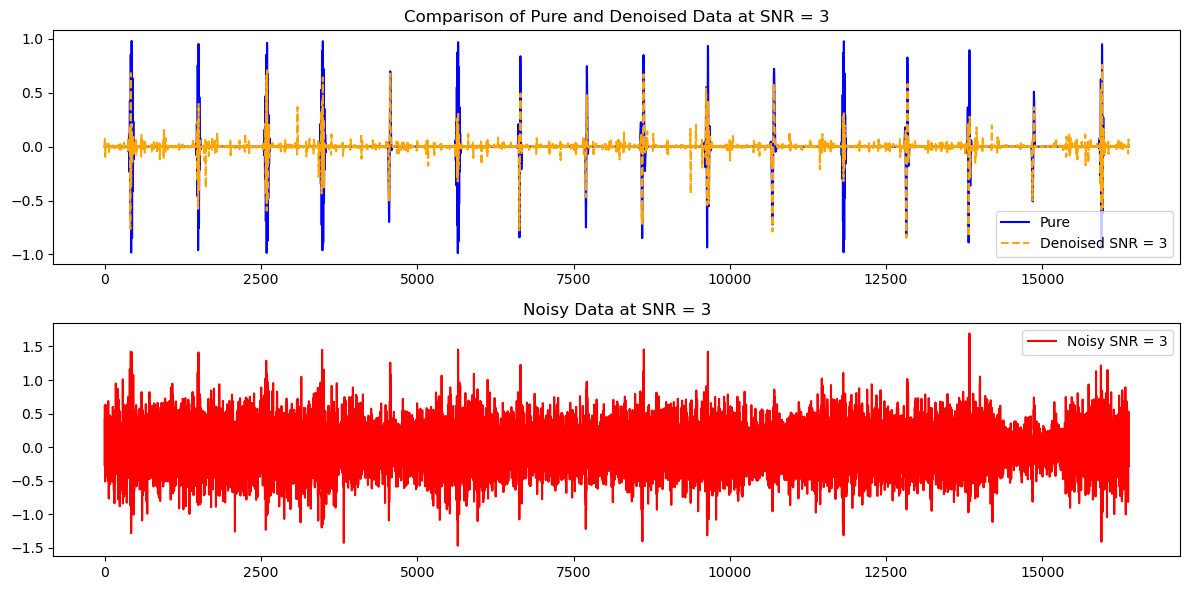

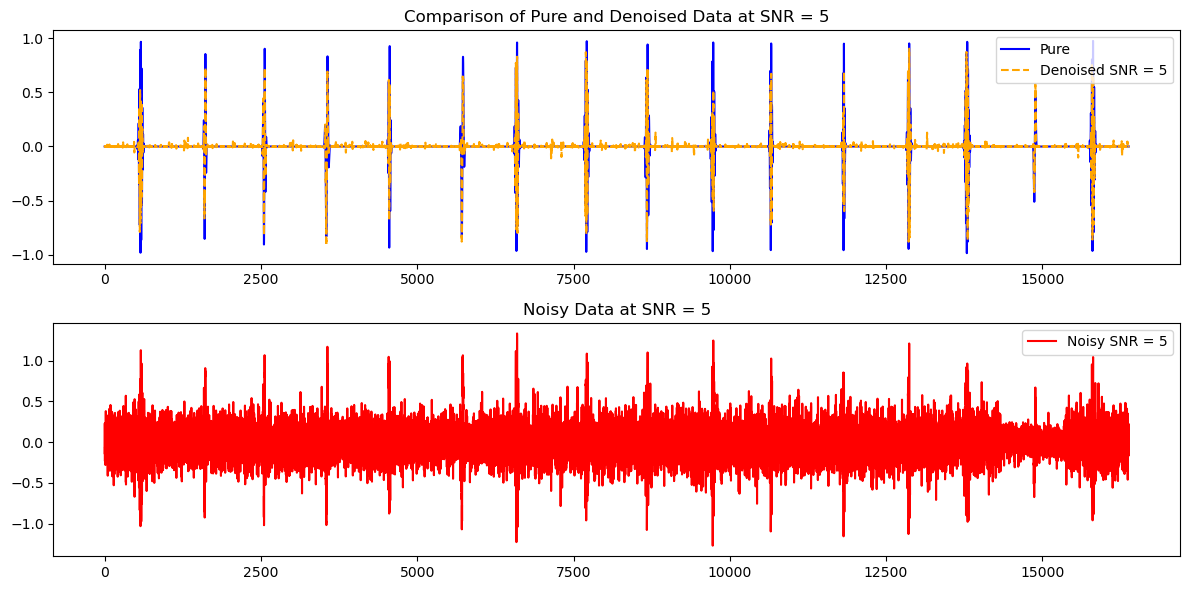

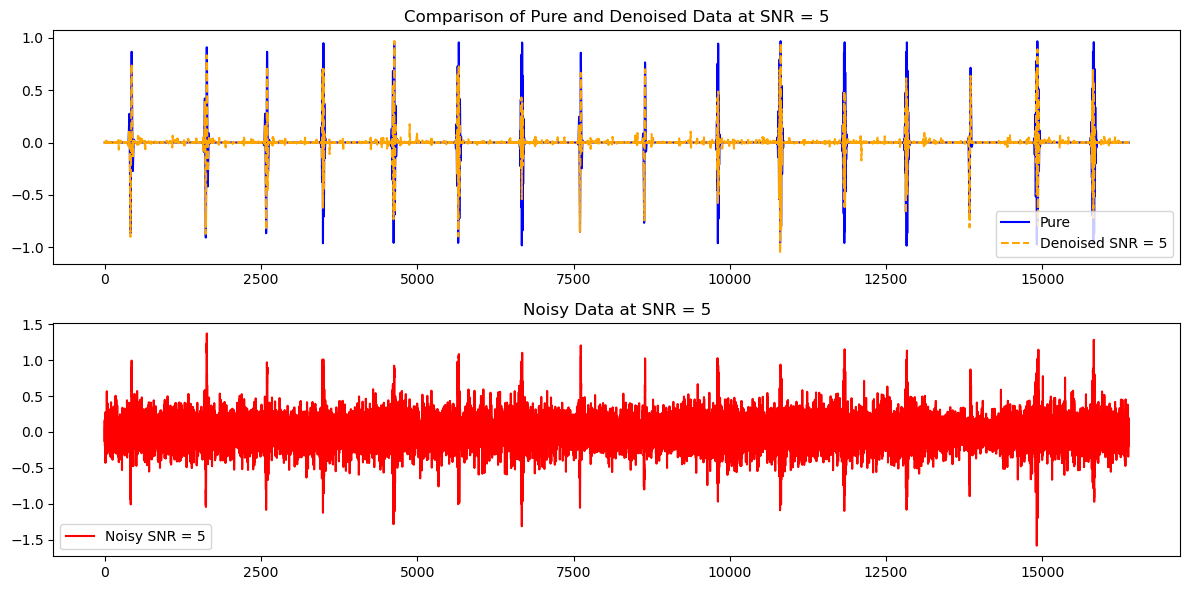

Evaluation of Test dataset is complete


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import random_split

# Set environment variable for MacOS compatibility
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Function to generate a trace
def create_trace(ts, tssig, omega, sigma):
    return np.sin(2. * np.pi * (ts - tssig) * omega) * np.exp(-(ts - tssig)**2 / sigma)

# Function to save a trace to CSV (optional)
def save_trace_to_csv(ts, trace, idat, directory):
    df = pd.DataFrame({'Time': ts, 'Trace': trace})
    filename = os.path.join(directory, f'trace_data_{idat}.csv')
    df.to_csv(filename, index=False)
    print(f'Data saved to {filename}')

# Function to generate dataset
def generate_dataset(ts, ndat, directory, save_csv):
    dataset = []
    parameters = []
    for idat in range(ndat):
        tssig = random.uniform(512 - 100, 512 + 100)
        omega = random.uniform(0.01, 0.1)
        sigma = random.uniform(200, 800)
        trace = create_trace(ts, tssig, omega, sigma)
        dataset.append([trace])
        parameters.append((tssig, omega, sigma))
        if save_csv:
            save_trace_to_csv(ts, trace, idat, directory)
    return torch.tensor(np.array(dataset), dtype=torch.float32), parameters

# Function to visualize dataset
def visualize_dataset(ts, dataset_tensor, parameters, ndat):
    for i in range(ndat):
        fig, axs = plt.subplots(figsize=(16, 4))
        trace = np.array(dataset_tensor)[i, 0, :]
        label = f'tssig={parameters[i][0]:.2f}, omega={parameters[i][1]:.5f}, sigma={parameters[i][2]:.2f}'
        axs.plot(ts, trace, color='r', label=label)
        axs.legend(loc='upper right')
        axs.set_title('Trace')
        axs.set(xlabel='time', ylabel='Amplitude')
        plt.show()

# Custom dataset class for adding noise
class NoisyDataset(Dataset):
    def __init__(self, original_dataset, snr_value):
        self.original_dataset = original_dataset
        self.snr_value = abs(snr_value)
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        pure_data = self.original_dataset[idx]
        if not isinstance(pure_data, torch.Tensor):
            pure_data = torch.tensor(pure_data, dtype=torch.float32)
        
        # Calculate the noise level based on the SNR
        signal_abs = torch.abs(pure_data)
        S = torch.max(signal_abs)
        N = S / self.snr_value
        noise = torch.normal(0, N.item(), pure_data.size())
        
        # The noisy data is the input feature and the pure data is the target for training
        noisy_data = pure_data + noise
        return noisy_data, pure_data

# Function to generate datasets per SNR
def generate_dataset_per_snr(ts, ndat_per_snr, directory, snr_values, save_csv):
    datasets = {}
    for snr in snr_values:
        dataset, parameters = generate_dataset(ts, ndat_per_snr, directory, save_csv)
        noisy_dataset = NoisyDataset(dataset, snr)
        datasets[snr] = noisy_dataset
    return datasets

# Time steps
ts = np.arange(0, 1024, 1)

# SNR values
snr_values = [0.7, 0.9, 1, 3, 5]

# Generate datasets for each SNR value
datasets_per_snr = generate_dataset_per_snr(ts, 2000, "your_directory", snr_values, save_csv=False)

# Splitting datasets into training and testing
train_datasets = {}
test_datasets = {}

for snr, dataset in datasets_per_snr.items():
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_datasets[snr] = train_dataset
    test_datasets[snr] = test_dataset

# Creating DataLoaders for each SNR
train_loaders = {snr: DataLoader(dataset, batch_size=16, shuffle=True) 
                 for snr, dataset in train_datasets.items()}
test_loaders = {snr: DataLoader(dataset, batch_size=16, shuffle=False) 
                for snr, dataset in test_datasets.items()}

# Autoencoder model
class Autoencoder(nn.Module):
    """An Autoencoder model with batch normalization."""
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(32, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
num_epochs = 100
train_losses = []
test_losses = []
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    num_train_batches = 0

    # Training phase
    for snr, train_loader in train_loaders.items():
        for data in train_loader:
            # Adjusted to match the NoisyDataset output
            pure_data, noisy_data = data[1].to(device), data[0].to(device)
            optimizer.zero_grad()
            outputs = model(noisy_data)
            loss = criterion(outputs, pure_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1

    avg_train_loss = train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    num_test_batches = 0

    with torch.no_grad():
        for snr, test_loader in test_loaders.items():
            for data in test_loader:
                # Adjusted to match the NoisyDataset output
                pure_data, noisy_data = data[1].to(device), data[0].to(device)
                outputs = model(noisy_data)
                loss = criterion(outputs, pure_data)
                test_loss += loss.item()
                num_test_batches += 1

    avg_test_loss = test_loss / num_test_batches
    test_losses.append(avg_test_loss)

    # Save model checkpoint if test loss improved
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), 'autoencoder_best.pth')

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    scheduler.step()  # Update learning rate

    # Early stopping logic can be added here based on your criteria

# Plot training and test losses
# Plot losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation of the model
model.eval()
max_plots_per_snr = 2

with torch.no_grad():
    for snr_value in snr_values:
        if snr_value in test_loaders:
            test_loader = test_loaders[snr_value]
            plot_counter = 0

            for data in test_loader:
                noisy_data, pure_data = data
                pure_data = pure_data.to(device).view(-1, 1, pure_data.size(-1))
                noisy_data = noisy_data.to(device).view(-1, 1, noisy_data.size(-1))
                denoised_output = model(noisy_data).detach().cpu().view(-1)

                if plot_counter >= max_plots_per_snr:
                    break

                plt.figure(figsize=(12, 6))
                plt.subplot(2, 1, 1)
                plt.plot(pure_data.view(-1).cpu(), label='Pure', color='blue')
                plt.plot(denoised_output, label=f'Denoised SNR = {snr_value}', linestyle='--', color='orange')
                plt.title(f'Comparison of Pure and Denoised Data at SNR = {snr_value}')
                plt.legend()
                plt.subplot(2, 1, 2)
                plt.plot(noisy_data.view(-1).cpu(), label=f'Noisy SNR = {snr_value}', color='red')
                plt.title(f'Noisy Data at SNR = {snr_value}')
                plt.legend()
                plt.tight_layout()
                plt.show()

                plot_counter += 1
        else:
            print(f'No data available for SNR value: {snr_value}')

print('Evaluation of Test dataset is complete')


In [15]:
model.eval()  # Set the model to evaluation mode
snr_values = [0.7, 0.9, 1, 3, 5]  # Example SNR values
max_plots_per_snr = 2  # Set this to the desired number of plots per SNR
with torch.no_grad():
    for snr_value in snr_values:
        noisy_test_loader = DataLoader(NoisyDataset(test_dataset, snr_value=snr_value), batch_size=1, shuffle=False)
        
        plot_counter = 0  # Initialize plot counter for each SNR

        for pure_data, noisy_data, _ in noisy_test_loader:
            if plot_counter >= max_plots_per_snr:
                break  # Stop plotting if max plots per SNR are reached

            pure_data, noisy_data = pure_data.to(device), noisy_data.to(device)
            denoised_output = model(noisy_data)

            # Visualization
            plt.figure(figsize=(18, 6))

            # Subplot for Pure and Denoised data
            plt.subplot(2, 1, 1)
            plt.plot(pure_data.cpu().squeeze(), label='Pure', color='blue')
            plt.plot(denoised_output.cpu().squeeze(), label=f'Denoised SNR = {snr_value}', linestyle='--', color='orange')
            plt.title(f'Comparison of Pure and Denoised Data at SNR = {snr_value}')
            plt.legend(fontsize=16)

            # Subplot for Noisy data
            plt.subplot(2, 1, 2)
            plt.plot(noisy_data.cpu().squeeze(), label=f'Noisy SNR = {snr_value}', color='red')
            plt.title(f'Noisy Data at SNR = {snr_value}')
            plt.legend(fontsize=16)

            plt.tight_layout()
            plt.show()

            plot_counter += 1  # Increment plot counter

print('Evaluation of Test dataset is complete')

ValueError: only one element tensors can be converted to Python scalars